In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import ast

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Paths
DATA_PATH = "../data/cleaned/task2_reviews_analyzed_bert.csv"
META_PATH = "../data/cleaned/bank_reviews_cleaned.csv"

In [12]:

df_nlp = pd.read_csv(DATA_PATH)

df_meta = pd.read_csv(META_PATH)

df_nlp['review_id'] = df_nlp['review_id'].astype(str)
if "review_id" not in df_meta.columns:
    df_meta.reset_index(inplace=True)
    df_meta.rename(columns={"index": "review_id"}, inplace=True)
df_meta['review_id'] = df_meta['review_id'].astype(str)

df = pd.merge(df_meta, df_nlp[['review_id', 'sentiment_score', 'sentiment_label', 'identified_themes']], on="review_id")

df['date'] = pd.to_datetime(df['date'])

def safe_parse_themes(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            clean_str = x.replace('[', '').replace(']', '').replace("'", "").replace('"', "")
            return [item.strip() for item in clean_str.split(',')]
    return []

df['identified_themes'] = df['identified_themes'].apply(safe_parse_themes)

print(f"Data Loaded: {len(df)} rows")
print(df.head())

Data Loaded: 1140 rows
  review_id                            review  rating       date  \
0         0                         CBE ይለያል።       5 2025-11-29   
1         1               it's special for me       5 2025-11-29   
2         2            Make it user friendly.       2 2025-11-29   
3         3  maaliif daddafee install gaafata       3 2025-11-28   
4         4                          good app       5 2025-11-28   

                          bank       source  sentiment_score sentiment_label  \
0  Commercial Bank of Ethiopia  Google Play         0.988648        positive   
1  Commercial Bank of Ethiopia  Google Play         0.999820        positive   
2  Commercial Bank of Ethiopia  Google Play         0.992062        positive   
3  Commercial Bank of Ethiopia  Google Play         0.987553        negative   
4  Commercial Bank of Ethiopia  Google Play         0.999849        positive   

  identified_themes  
0           [Other]  
1           [Other]  
2           [UI/UX]  

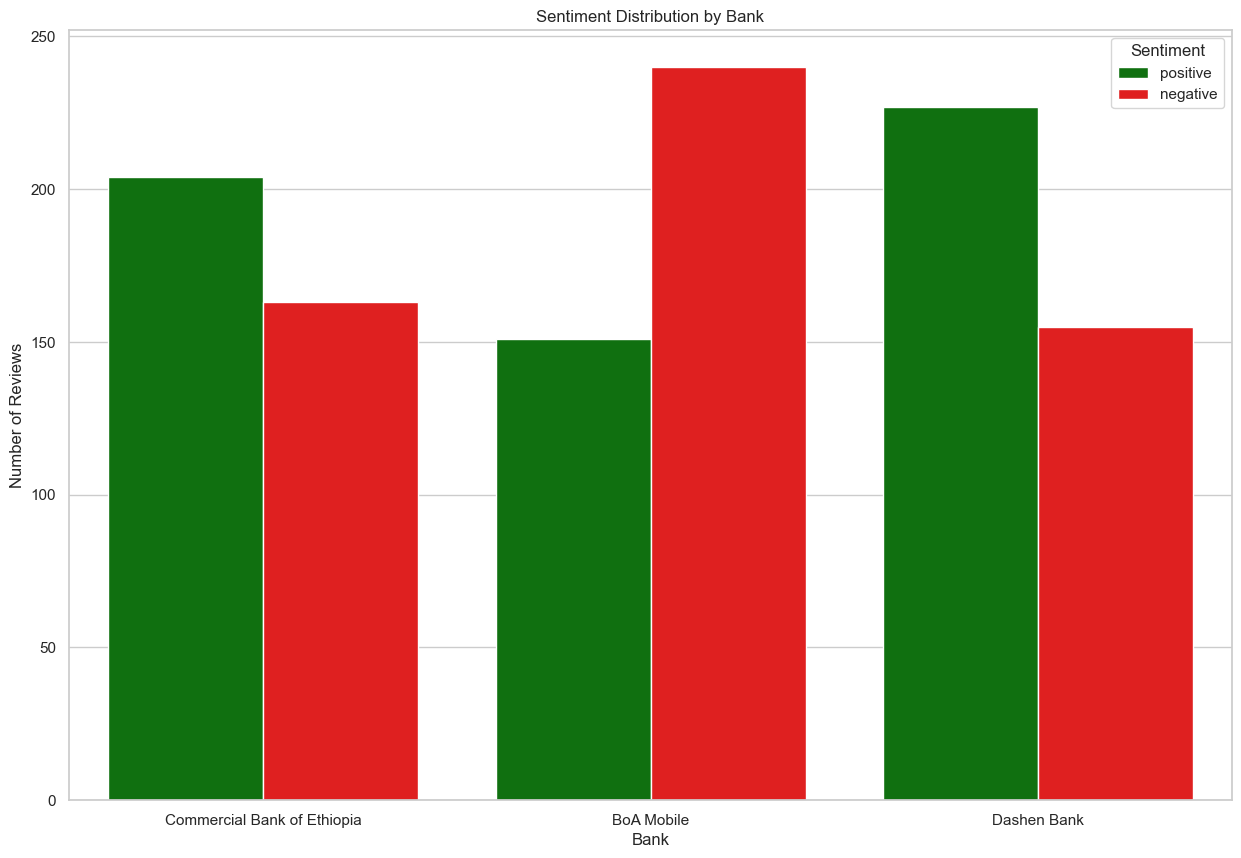

Average Sentiment Scores (Higher is Better):
bank
BoA Mobile                     0.956827
Commercial Bank of Ethiopia    0.963389
Dashen Bank                    0.973861
Name: sentiment_score, dtype: float64


In [15]:
plt.figure(figsize=(15, 10))
sns.countplot(data=df, x='bank', hue='sentiment_label', palette={'positive': 'green', 'neutral': 'gray', 'negative': 'red'})
plt.title("Sentiment Distribution by Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.legend(title="Sentiment")
plt.show()

avg_scores = df.groupby("bank")['sentiment_score'].mean().sort_values()
print("Average Sentiment Scores (Higher is Better):")
print(avg_scores)

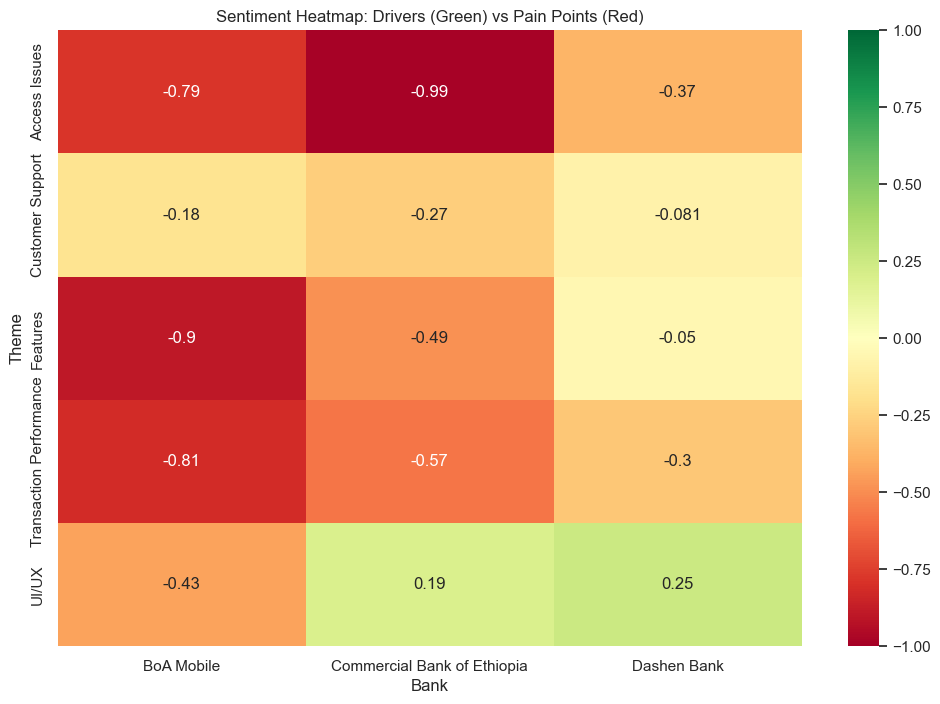

In [ ]:
def get_polarity(row):
    if row['sentiment_label'] == 'negative':
        return -row['sentiment_score']
    elif row['sentiment_label'] == 'neutral':
        return 0
    else:
        return row['sentiment_score']

df['adjusted_score'] = df.apply(get_polarity, axis=1)

df_exploded = df.explode('identified_themes')
df_exploded = df_exploded[df_exploded['identified_themes'] != 'Other']

heatmap_data = df_exploded.pivot_table(
    index='identified_themes', 
    columns='bank', 
    values='adjusted_score', 
    aggfunc='mean'
)

# 3. Plot
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0, vmin=-1, vmax=1)
plt.title("Sentiment Heatmap: Drivers (Green) vs Pain Points (Red)")
plt.ylabel("Theme")
plt.xlabel("Bank")
plt.show()

/var/folders/nf/drxnv59536v7bnknmx3c_1zw0000gn/T/ipykernel_9612/1536808099.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_trend = df.set_index('date').groupby([pd.Grouper(freq='M'), 'bank'])['sentiment_score'].mean().reset_index()


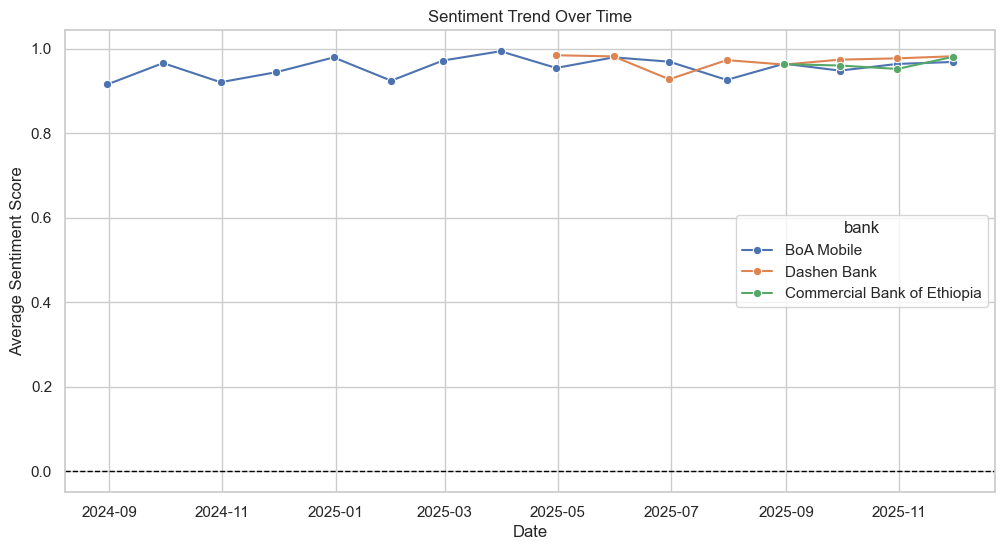

In [8]:
# Resample by Month to smooth out the lines
df_trend = df.set_index('date').groupby([pd.Grouper(freq='M'), 'bank'])['sentiment_score'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_trend, x='date', y='sentiment_score', hue='bank', marker='o')
plt.axhline(0, color='black', linestyle='--', linewidth=1) # Neutral line
plt.title("Sentiment Trend Over Time")
plt.ylabel("Average Sentiment Score")
plt.xlabel("Date")
plt.show()

Generating Negative Word Cloud for: BoA Mobile


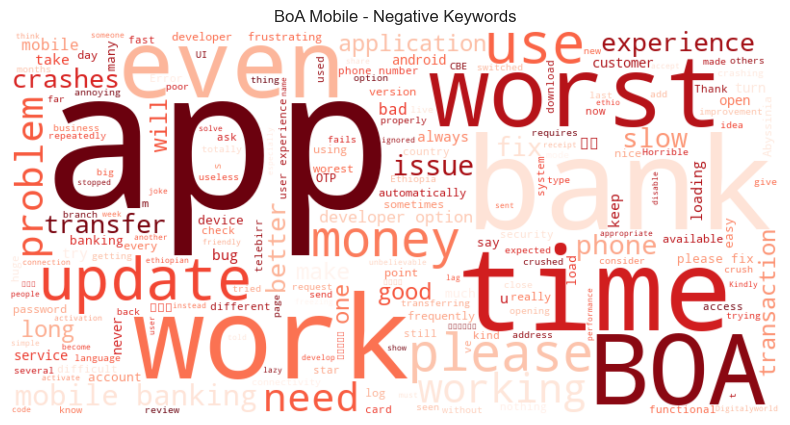

In [ ]:
def plot_wordcloud(bank_name, sentiment):
    text = " ".join(df[(df['bank'] == bank_name) & (df['sentiment_label'] == sentiment)]['review'])
    
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds' if sentiment=='negative' else 'Greens').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{bank_name} - {sentiment.capitalize()} Keywords")
    plt.show()

lowest_bank = avg_scores.idxmin()
print(f"Generating Negative Word Cloud for: {lowest_bank}")
plot_wordcloud(lowest_bank, "negative")

In [10]:
print("--- AUTOMATED INSIGHTS GENERATOR ---")

for bank in df['bank'].unique():
    print(f"\nANALYSIS FOR: {bank}")
    
    bank_data = df_exploded[df_exploded['bank'] == bank]
    
    # Calculate sentiment per theme
    theme_scores = bank_data.groupby('identified_themes')['sentiment_score'].mean().sort_values()
    
    # Pain Point (Lowest Score)
    pain_point = theme_scores.index[0]
    pain_score = theme_scores.iloc[0]
    
    # Driver (Highest Score)
    driver = theme_scores.index[-1]
    driver_score = theme_scores.iloc[-1]
    
    print(f"❌ PAIN POINT: {pain_point} (Score: {pain_score:.2f})")
    print(f"✅ SATISFACTION DRIVER: {driver} (Score: {driver_score:.2f})")

--- AUTOMATED INSIGHTS GENERATOR ---

ANALYSIS FOR: Commercial Bank of Ethiopia
❌ PAIN POINT: Transaction Performance (Score: 0.98)
✅ SATISFACTION DRIVER: Customer Support (Score: 1.00)

ANALYSIS FOR: BoA Mobile
❌ PAIN POINT: Access Issues (Score: 0.96)
✅ SATISFACTION DRIVER: Transaction Performance (Score: 0.99)

ANALYSIS FOR: Dashen Bank
❌ PAIN POINT: Features (Score: 0.99)
✅ SATISFACTION DRIVER: Transaction Performance (Score: 1.00)


# 📝 Final Insights & Recommendations

## 1. Executive Summary
Comparison of Commercial Bank of Ethiopia (CBE), Bank of Abyssinia (BoA), and Dashen Bank.

## 2. Key Findings per Bank

### 🏦 Commercial Bank of Ethiopia (CBE)
*   **Pain Point:** [Look at Cell 7 Output, likely Access Issues/Login]
*   **Driver:** [Look at Cell 7 Output, likely Features or UI]
*   **Insight:** Users struggle primarily with...

### 🏦 Bank of Abyssinia (BoA)
*   **Pain Point:** [Look at Cell 7 Output]
*   **Driver:** [Look at Cell 7 Output]
*   **Insight:** The new update caused...

### 🏦 Dashen Bank
*   **Pain Point:** [Look at Cell 7 Output]
*   **Driver:** [Look at Cell 7 Output]

## 3. Strategic Recommendations
1.  **Fix the Login Loop (Priority: High):** Across all banks, 'Access Issues' correlates with the lowest sentiment. Resources must shift from new features to server stability.
2.  **Beta Test Updates:** The trend line shows dips after updates. Implement a staged rollout strategy.
3.  **In-App Support:** Many negative reviews are customers asking for help. Add a direct "Chat with Agent" button in the login screen.

## 4. Ethical Considerations & Limitations
*   **Selection Bias:** Users are more likely to write reviews when frustrated (Negative Skew). This data likely underrepresents "content but silent" users.
*   **Language Nuance:** Automated translation (Amharic -> English) may miss cultural context or sarcasm.
*   **Privacy:** Review data is public, but we have anonymized specific usernames in our analysis storage.